Imagine we are tasked with predicting the amount of points an NBA player will generate in a game. 
This notebook contains a step-by-step guide on how to model that using some of the tools by spforge.



In [1]:
import pandas as pd
from spforge.transformers import LagTransformer, RollingMeanTransformer
df = pd.read_parquet("data/game_player_subsample.parquet")
df.head()

,team_id,start_date,game_id,player_id,player_name,start_position,team_id_opponent,points,game_minutes,minutes,won,plus_minus,location,score,score_opponent
38956,1610612755,2022-10-18,0022200001,202699,Tobias Harris,F,1610612738,18.0,48.0,34.233,0,-1.0,away,117,126
38957,1610612755,2022-10-18,0022200001,200782,P.J. Tucker,F,1610612738,6.0,48.0,33.017,0,-6.0,away,117,126
38958,1610612755,2022-10-18,0022200001,203954,Joel Embiid,C,1610612738,26.0,48.0,37.267,0,-13.0,away,117,126
38959,1610612755,2022-10-18,0022200001,1630178,Tyrese Maxey,G,1610612738,21.0,48.0,38.200,0,-6.0,away,117,126
38960,1610612755,2022-10-18,0022200001,201935,James Harden,G,1610612738,35.0,48.0,37.267,0,1.0,away,117,126


In [2]:
print(f"Data from {df['start_date'].min()} to {df['start_date'].max()} | "
      f"Total rows: {len(df):,} | Unique games: {df['game_id'].nunique():,}")


Data from 2022-10-18 to 2023-02-01 | Total rows: 19,872 | Unique games: 776


To start, let's quickly check if the data roughly matches what we expect given domain knowledge. Do the highes scoring NBA players such as Luca Doncic and Giannis have the highest points per game?

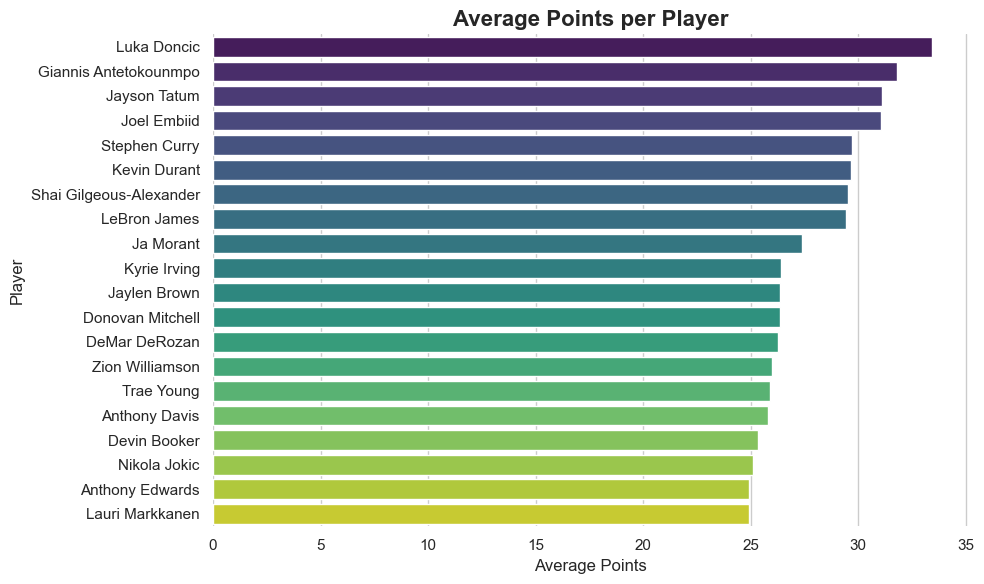

In [3]:
import importlib.util
import subprocess
import sys

if importlib.util.find_spec("seaborn") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_avg = (
    df.groupby('player_name')['points']
    .mean()
    .reset_index()
    .sort_values(by='points', ascending=False)
).head(20)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_avg,
    y='player_name',
    x='points',
    palette='viridis'  
)

plt.title('Average Points per Player', fontsize=16, weight='bold')
plt.xlabel('Average Points', fontsize=12)
plt.ylabel('Player', fontsize=12)

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.show()


Some of the features that could be predictive of future points scored:
* Previous Points scored
* Previous Minutes played
* Previous points_per_minute

In spforge, we can calculate a players past performances in a few different ways. One of the more straight-forward approaches is through a RollingMeanTransformer as seen below.



In [4]:
df['points_per_minute'] = df['points'] / df['minutes']
df = df.sort_values(by=['start_date'])
rm_transformer_window20 = RollingMeanTransformer(
    features=['points', 'points_per_minute', 'minutes'],
    granularity=['player_id'],
    window=20,
    update_column='game_id'
)
df = rm_transformer_window20.transform_historical(df)
df[['player_name',*rm_transformer_window20.features_out]].tail()

,player_name,rolling_mean_points20,rolling_mean_points_per_minute20,rolling_mean_minutes20
19867,Luke Kornet,2.50,0.370794,8.05505
19868,Payton Pritchard,4.25,0.361252,12.19000
19869,Sam Hauser,3.60,0.340526,10.72580
19870,Andrew Wiggins,14.70,0.530857,27.26835
19871,Jock Landale,5.95,0.458732,12.73335


Below is Jayson Tatum's 20-window Rolling Mean.

<Axes: title={'center': 'Jayson Tatum Rolling Mean Points'}, xlabel='start_date'>

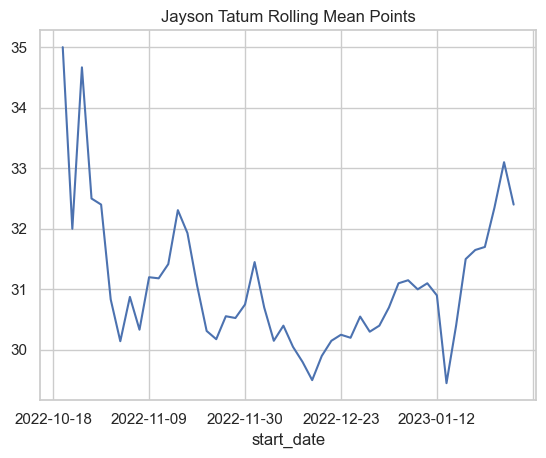

In [5]:
df[df['player_name']=='Jayson Tatum'].set_index('start_date')['rolling_mean_points20'].plot(title="Jayson Tatum Rolling Mean Points")

In [6]:
df[[*rm_transformer_window20.features_out, 'points']].corr()

,rolling_mean_points20,rolling_mean_points_per_minute20,rolling_mean_minutes20,points
rolling_mean_points20,1.000000,0.680584,0.877593,0.768597
rolling_mean_points_per_minute20,0.680584,1.000000,0.436541,0.506432
rolling_mean_minutes20,0.877593,0.436541,1.000000,0.684632
points,0.768597,0.506432,0.684632,1.000000


All of the 3 features correlate quite strongly with points scored which indicate that they make sense to use as features to our final machine-learning model.
Below we split into train and test data.

In [7]:
from lightgbm import LGBMRegressor
unique_dates = df['start_date'].unique().tolist()
train_max_date = unique_dates[int(len(unique_dates)*0.7)]
train = df[df['start_date']<=train_max_date]
test = df[df['start_date']>train_max_date]
len(train), len(test)



(14056, 5816)

We use a LGBMRegressor as the machine-learning model with a low max_depth as we only have 3 features with a relatively straight-forward relationship with the target.

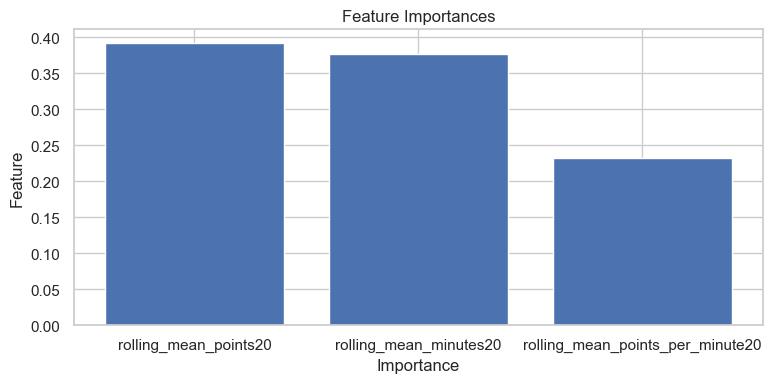

In [8]:
features = rm_transformer_window20.features_out
estimator =LGBMRegressor(verbose=-100, max_depth=3)
estimator.fit(train[features], train['points'])
feature_importances = [f/sum(estimator.feature_importances_) for f in estimator.feature_importances_]
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 4))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


Mean absolute error: 4.276420550366981


C:\Users\Admin\AppData\Local\Temp\ipykernel_27732\2630693530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_points'] = estimator.predict(test[features])


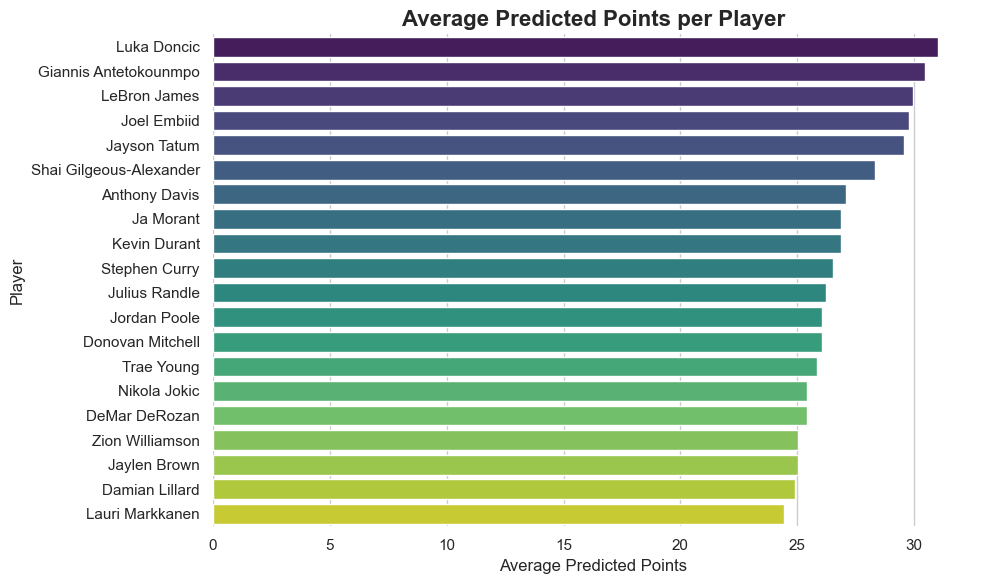

In [9]:
test['predicted_points'] = estimator.predict(test[features])
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['points'], test['predicted_points'])
print(f"Mean absolute error: {mae}")

df_avg = (
    test.groupby('player_name')['predicted_points']
    .mean()
    .reset_index()
    .sort_values(by='predicted_points', ascending=False)
).head(20)


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_avg,
    y='player_name',
    x='predicted_points',
    palette='viridis' 
)


plt.title('Average Predicted Points per Player', fontsize=16, weight='bold')
plt.xlabel('Average Predicted Points', fontsize=12)
plt.ylabel('Player', fontsize=12)


sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.show()


Above we can see that the predicted points generally aligns with what we expected from the entire historical dataset.
This indicates that the model's output isn't completely off.

In [10]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['points'], test['predicted_points'])
print(f"Mean absolute error: {mae}")

Mean absolute error: 4.276420550366981


The mean absolute error is 4.27.

We can probably improve upon that by adding additional features. Instead of only having a single window =20 for rolling mean, let's try and add multiple windows of different lengths and let's also add the past 5 lags for the player. 

In [11]:
rm_transformer_window10 = RollingMeanTransformer(
    features=['points', 'points_per_minute', 'minutes'],
    granularity=['player_id'],
    window=10,
    update_column='game_id'
)
df = rm_transformer_window10.transform_historical(df)
rm_transformer_window5 = RollingMeanTransformer(
    features=['points', 'points_per_minute', 'minutes'],
    granularity=['player_id'],
    window=5,
    update_column='game_id'
)
df = rm_transformer_window5.transform_historical(df)
rm_transformer_window40 = RollingMeanTransformer(
    features=['points', 'points_per_minute', 'minutes'],
    granularity=['player_id'],
    window=40,
    update_column='game_id'
)
df = rm_transformer_window40.transform_historical(df)

lag_transformer = LagTransformer(
    features=['points', 'points_per_minute', 'minutes'],
    granularity=['player_id'],
    lag_length=5,
    update_column='game_id'
)
df = lag_transformer.transform_historical(df)
df.tail()


,location,rolling_mean_minutes20,lag_minutes3,lag_points2,start_date,points,score_opponent,start_position,lag_minutes2,lag_minutes1,...,rolling_mean_points_per_minute40,points_per_minute,lag_points4,won,team_id_opponent,lag_points5,rolling_mean_points5,rolling_mean_points20,rolling_mean_minutes5,lag_points_per_minute1
19867,home,8.05505,12.517,0.0,2023-02-01,12.0,96,,4.167,16.350,...,0.360026,0.638298,4.0,1,1610612751,2.0,3.0,2.50,11.2102,0.122324
19868,home,12.19000,42.467,7.0,2023-02-01,5.0,96,,12.850,5.500,...,0.366456,0.309598,5.0,1,1610612751,12.0,6.8,4.25,23.4966,0.000000
19869,home,10.72580,25.800,8.0,2023-02-01,8.0,96,,8.400,5.233,...,0.324339,0.666667,13.0,1,1610612751,0.0,4.2,3.60,11.6600,0.000000
19870,away,27.26835,26.800,0.0,2023-02-01,16.0,119,F,0.000,32.250,...,0.541382,0.455412,20.0,0,1610612750,14.0,10.6,14.70,26.1134,0.465116
19871,home,12.73335,4.500,0.0,2023-02-01,6.0,132,,0.000,8.917,...,0.441515,0.570505,15.0,0,1610612737,12.0,6.6,5.95,10.2066,0.448581


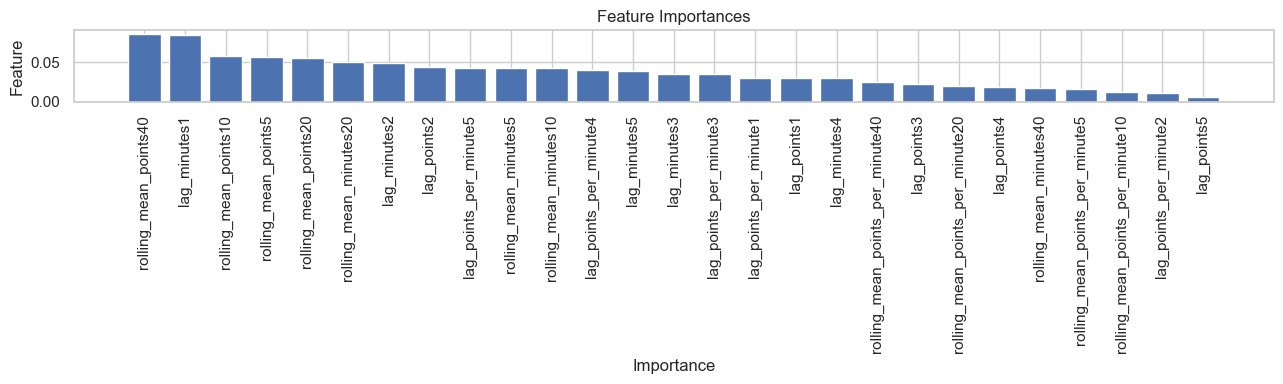

In [12]:
all_features = (rm_transformer_window20.features_out +
lag_transformer.features_out +
rm_transformer_window10.features_out +
rm_transformer_window5.features_out+ 
rm_transformer_window40.features_out)
train = df[df['start_date']<=train_max_date]
test = df[df['start_date']>train_max_date]
estimator_all_feats =LGBMRegressor(verbose=-100, max_depth=3, random_state=42)
estimator_all_feats.fit(train[all_features], train['points'])
feature_importances = [f/sum(estimator_all_feats.feature_importances_) for f in estimator_all_feats.feature_importances_]
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(13, 4))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [13]:
test.loc[:, 'predicted_points_all_features'] = estimator_all_feats.predict(test[all_features])
mae = mean_absolute_error(test['points'], test['predicted_points_all_features'])
print(f"Mean absolute error All Features Model: {mae}")

Mean absolute error All Features Model: 4.141203325196941


C:\Users\Admin\AppData\Local\Temp\ipykernel_27732\3537748462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted_points_all_features'] = estimator_all_feats.predict(test[all_features])


As expected we get a better mean absolute error. 

However, this process has been a bit tedious. We had to manually add all the features from the various transformers. We had to create the train-test split ourself. And we didn't even utilise proper cross-validation with multiple splits. If we had add more splits, it would be even more complex. 

And while we so far are only exploring historical data. How would we go about implementing the lag-and-rolling mean transformers for future games. To calculate future games, it would need to have acccess to the historical data as well which increases complexity. 

Luckily, the spforge Pipeline is designed to do all of these things with little input from the user.

In [14]:
from spforge import Pipeline, ColumnNames
from spforge.predictor import SklearnPredictor
#Reloading original dataframe to ensure we start all over from scratch
df = pd.read_parquet("data/game_player_subsample.parquet")
df['points_per_minute'] = df['points'] / df['minutes']
train = df[df['start_date']<=train_max_date]
test = df[df['start_date']>train_max_date]
column_names = ColumnNames(
    team_id="team_id",
    match_id="game_id",
    start_date="start_date",
    player_id="player_id"    
)
predictor = SklearnPredictor(estimator=LGBMRegressor(max_depth=4,verbose=-100), target='points')

pipeline = Pipeline(
    lag_transformers = [lag_transformer, rm_transformer_window5, rm_transformer_window10, rm_transformer_window20, rm_transformer_window40],
    predictor = predictor,
    column_names=column_names
)

pipeline.train(train)
test = pipeline.predict(test, cross_validation=True, return_features=True)
test.tail()

,team_id,start_date,game_id,player_id,player_name,start_position,team_id_opponent,points,game_minutes,minutes,...,rolling_mean_points10,rolling_mean_points_per_minute40,lag_points4,lag_points5,rolling_mean_points5,rolling_mean_points20,rolling_mean_minutes5,lag_points_per_minute1,__index_level_0__,points_prediction
5811,1610612756,2023-02-01,0022200777,1630240,Saben Lee,,1610612737,6.0,48.0,21.483,...,7.0,0.408519,2.0,2.0,2.6,4.75,11.3866,0.243902,5811,3.894053
5812,1610612756,2023-02-01,0022200777,202687,Bismack Biyombo,,1610612737,2.0,48.0,10.000,...,4.7,0.238340,6.0,4.0,4.4,3.50,16.0366,0.000000,5812,3.947725
5813,1610612756,2023-02-01,0022200777,1629006,Josh Okogie,,1610612737,2.0,48.0,15.367,...,7.9,0.332259,9.0,4.0,3.6,6.00,12.8568,0.514315,5813,4.169122
5814,1610612756,2023-02-01,0022200777,1630688,Ish Wainright,,1610612737,4.0,48.0,18.950,...,3.8,0.283909,2.0,0.0,2.4,3.80,8.4200,0.350298,5814,4.572205
5815,1610612756,2023-02-01,0022200777,1629111,Jock Landale,,1610612737,6.0,48.0,10.517,...,6.2,0.441515,15.0,12.0,6.6,5.95,10.2066,0.448581,5815,4.517048


In [15]:
mae = mean_absolute_error(test['points'], test[pipeline.pred_column])
print(f"Mean absolute error Pipeline Model: {mae}")

Mean absolute error Pipeline Model: 4.154825682946505


As seen below the same features are used by the LGBM Regressor

In [16]:
print(pipeline.predictor.features)

['lag_minutes3', 'rolling_mean_minutes20', 'lag_points2', 'lag_minutes2', 'lag_minutes1', 'lag_points_per_minute4', 'lag_minutes5', 'rolling_mean_points_per_minute5', 'lag_points_per_minute2', 'lag_points1', 'lag_points_per_minute3', 'rolling_mean_points40', 'rolling_mean_minutes10', 'lag_points3', 'rolling_mean_points_per_minute10', 'rolling_mean_points_per_minute20', 'rolling_mean_minutes5', 'rolling_mean_minutes40', 'lag_minutes4', 'rolling_mean_points10', 'rolling_mean_points_per_minute40', 'lag_points4', 'lag_points5', 'rolling_mean_points5', 'rolling_mean_points20', 'lag_points_per_minute5', 'lag_points_per_minute1']


More experienced users of machine-learning may be aware that performing only a single train-test split is not the best practice. Ideally we perform cross_validation with multiple splits. 

spforge has support for that as well. 

In [17]:
from spforge.cross_validator import MatchKFoldCrossValidator

cross_validator = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = pipeline,
)
df = cross_validator.generate_validation_df(df,  add_train_prediction=True, return_features=True)
df.tail()

,location,lag_minutes3,rolling_mean_minutes20,lag_points2,start_date,points,rolling_mean_points20,score_opponent,start_position,lag_minutes2,...,rolling_mean_points_per_minute40,points_per_minute,lag_points4,won,team_id_opponent,lag_points5,rolling_mean_points5,is_validation,rolling_mean_minutes5,lag_points_per_minute1
3297,home,4.400,11.426063,7.0,2023-02-01,6.0,4.75,132,,13.767,...,0.408519,0.279291,2.0,0,1610612737,2.0,2.6,1,11.3866,0.243902
3298,home,9.533,12.359250,8.0,2023-02-01,2.0,3.50,132,,16.017,...,0.238340,0.200000,6.0,0,1610612737,4.0,4.4,1,16.0366,0.000000
3299,home,9.167,15.409200,2.0,2023-02-01,2.0,6.00,132,,11.750,...,0.332259,0.130149,9.0,0,1610612737,4.0,3.6,1,12.8568,0.514315
3300,home,13.383,14.785000,0.0,2023-02-01,4.0,3.80,132,,0.000,...,0.283909,0.211082,2.0,0,1610612737,0.0,2.4,1,8.4200,0.350298
3301,home,4.500,12.733350,0.0,2023-02-01,6.0,5.95,132,,0.000,...,0.441515,0.570505,15.0,0,1610612737,12.0,6.6,1,10.2066,0.448581


Note that we added a parameter to return predictions for the non-validated (training) data-split as well. There is a column is_validation that flags whether the predictions are from the non-validated predictions. 

Returning the non-validating predictions can be useful to evaluate difference between training data and validation data accuracy. But also in case where the prediction-output will be used as an input to another model.

To measure the cross-validated mean_absolute_error we need to import an Sklearn Scorer Wrapper. This wrapper will automatically filter out the training-data predictions.

In [18]:
from spforge.scorer import SklearnScorer
mean_absolute_scorer = SklearnScorer(pred_column=pipeline.pred_column, scorer_function=mean_absolute_error, target='points')
cross_validator.cross_validation_score(df, scorer=mean_absolute_scorer )

4.14637874050329

Some readers may think: But what about the opponent? So far we only evaluated using the players own historical stats. But if a player is facing a strong team chances are he will score fewer points. 

There are a few ways we can handle that. The simplest approach is to add the opponent as a categorical feature. 
Because we already calculated the lag-and-rolling-mean features we don't need to recalculate them. Because the pipeline has the same methods as a normal predictor, any predictor type can also be passed into MatchKFoldCrossValidator instead of the pipeline.

Instead we need to the opponent as a categorical feature along with the features generated by the pipeline. 
We also set convert_cat_features_to_cat_dtype to True. This ensures non-numeric features are converted to categorical.

In [19]:
predictor_cat_feats = SklearnPredictor(estimator=LGBMRegressor(max_depth=4,verbose=-100), target='points', features = ['team_id_opponent',*pipeline.features], 
                                       convert_cat_features_to_cat_dtype=True)

cross_validator_cat_feats = MatchKFoldCrossValidator(
    match_id_column_name='game_id',
    date_column_name='start_date',
    predictor = predictor_cat_feats,
)
df = cross_validator_cat_feats.generate_validation_df(df,  add_train_prediction=True)
cross_validator_cat_feats.cross_validation_score(df, scorer=mean_absolute_scorer )

4.143557491369502

This shows a small improvement. There are definitely better and more dynamic ways to take into account opponent. Rating Models are one way of doing that, but it's beyond the scope of this guide. 

Finally, let's assume we have a future match which we want to generate predictions for. So far we only performed cross-validation, but we never trained the pipline on the entire dataset. 


In [20]:
final_predictor = SklearnPredictor(estimator=LGBMRegressor(max_depth=4,verbose=-100), target='points', features = ['team_id_opponent'], 
                                       convert_cat_features_to_cat_dtype=True)
final_pipeline = Pipeline(
    lag_transformers = [lag_transformer, rm_transformer_window5, rm_transformer_window10, rm_transformer_window20, rm_transformer_window40],
    predictor = final_predictor,
    column_names=column_names
)

final_pipeline.train(df)


In [21]:
team_id_1= df['team_id'].iloc[0]
team_id_2= df['team_id_opponent'].iloc[1]
player_id_stephen_curry = df[df['player_name']=='Stephen Curry']['player_id'].iloc[1]
player_id_jayson_tatum = df[df['player_name']=='Jayson Tatum']['player_id'].iloc[1]
player_id_kevin_durant = df[df['player_name']=='Kevin Durant']['player_id'].iloc[1]
player_id_trae_young = df[df['player_name']=='Trae Young']['player_id'].iloc[1]
future_game = pd.DataFrame(
    {
        "game_id": ["99999"]* 4,
        "start_date": [pd.to_datetime(df['start_date'].max()) + pd.Timedelta(days=1)]*4,
        'team_id': [team_id_1, team_id_1, team_id_2, team_id_2 ],
        'team_id_opponent': [team_id_2, team_id_2, team_id_1, team_id_1 ],
        'player_id': [player_id_stephen_curry, player_id_jayson_tatum, player_id_kevin_durant, player_id_trae_young],
        'player_name':['Stephen Curry', 'Jayson Tatum', 'Kevin Durant', 'Trae Young']
    }
)
future_game.head()
final_pipeline.predict(future_game, return_features=True).head()[['player_name', final_pipeline.pred_column]]


,player_name,points_prediction
0,Stephen Curry,27.550397
1,Jayson Tatum,27.533133
2,Kevin Durant,29.312638
3,Trae Young,25.638063


The above example is obviously a nonsensical 2x2 match. The model knows nothing about the team-mates nor the amount of players on the opposing team. Thus it will generate pretty naive predictions that assumes a "normal" game.